In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Defining the time series

Code in the below cell is bliendly copied from the notebook of the course

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def generate_window_dataset(series, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer_size).map(lambda x: (x[:window_size], x[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [29]:
dataset = generate_window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
for window in dataset:
    print("Train_x shape of one batch : ", window[0].numpy().shape)
    print("Train_y shape of one batch : ", window[1].numpy().shape)
    break

Train_x shape of one batch :  (32, 20)
Train_y shape of one batch :  (32,)


In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [31]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 302.9628
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 141.3510
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 138.1696
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 131.7234
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 118.1198
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 116.4785
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 128.0300
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 99.3445
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 106.7690
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 97.0744
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 95.6993
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 95.2847
Epoch 13/100
31/3

In [32]:
weights = model.layers[0].get_weights()
print(weights[0].shape)
print(weights[1].shape)
weights

(20, 1)
(1,)


[array([[-0.04155958],
        [ 0.04217253],
        [-0.04515002],
        [ 0.05523665],
        [ 0.01478091],
        [-0.03457696],
        [-0.00588419],
        [ 0.0391994 ],
        [-0.07377342],
        [ 0.06596832],
        [-0.00268232],
        [-0.02772275],
        [-0.04025513],
        [ 0.0752218 ],
        [ 0.03982605],
        [-0.00318204],
        [ 0.06943402],
        [ 0.13094585],
        [ 0.34080052],
        [ 0.39533156]], dtype=float32),
 array([0.01333591], dtype=float32)]

# Forecast 

## Sample

In [46]:
t = series[split_time-window_size:split_time] #[np.newaxis]
# t = np.reshape(series[split_time-window_size:split_time], (1, len(t)))
t = t[np.newaxis]

model.predict(np.array(t))[0][0]

65.58609

## Forecast over test data

In [47]:
forecast = []
for index in range(split_time, len(series)):
    windowed_series = series[index-window_size: index][np.newaxis]
    pred = model.predict(windowed_series)[0][0]
    forecast.append(pred)

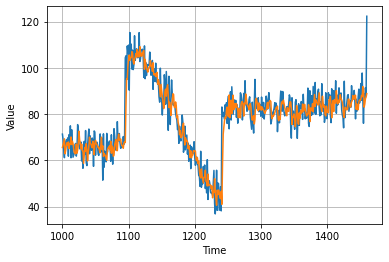

In [49]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

4.9342504